A little finite-difference code for fun. This code is based on a course a attended at MIT by Steven Johnson. He had a small implementation in Julia.

In [161]:
import numpy as np
from scipy.sparse import spdiags, identity, kron, linalg
from matplotlib import path

In [162]:
# Domain dimensions
Lx, Ly = 4 * np.pi, 4 * np.pi
# Lx, Ly = 7 * np.pi, 7 * np.pi

In [189]:
omega = 10  # wavenumber
# omega = 7
Lambda = 2 * np.pi / omega  # wavelength
res_per_lam = 20  # resolution (#pixels per wavelength)
refInd = 1.5 + 0j  # refractive index of scatterer
d = [0,-1]  # incident wave direction
d /= np.linalg.norm(d)
dx_temp = Lambda / res_per_lam
res = np.round(1 / dx_temp)

In [190]:
dpml = 1 * Lambda  # depth of PML
sigma0 = -np.log(1e-10) / (4*dpml/3)

In [191]:
M = np.int(round((Lx+2*dpml)*res))
N = np.int(round((Ly+2*dpml)*res))
dx = (Lx+2*dpml) / (M+1)
dy = (Ly+2*dpml) / (N+1)
x = np.arange(1, M+1) * dx - Lx/2 - dpml
y = np.arange(1, N+1) * dy - Ly/2 - dpml

In [192]:
# 1st derivative matrix
x_prime = (np.arange(0, M+1) + 0.5) * dx
y_prime = (np.arange(0, N+1) + 0.5) * dy

ox = np.ones(M) / dx
oy = np.ones(N) / dy

In [193]:
sigma_x = sigma0 * (x_prime < dpml)*(dpml - x_prime)**2 + \
    sigma0 * (x_prime > Lx + dpml)*(x_prime-(Lx+dpml))**2

sigma_y = sigma0 * (y_prime < dpml) * (dpml - y_prime)**2 + \
    sigma0 * (y_prime > Ly + dpml) * (y_prime-(Ly+dpml))**2

In [194]:
Dx = np.diag(1/(1+(1j/omega)*sigma_x)) * spdiags([-ox,ox],[-1,0],M+1,M)
Dy = np.diag(1/(1+(1j/omega)*sigma_y)) * spdiags([-oy,oy],[-1,0],N+1,N)

In [195]:
Ix = identity(M)
Iy = identity(N)

In [196]:
# The differentiation operators in absence of PML (used for RHS)
Dx_free = spdiags([-ox,ox],[-1,0],M+1,M)
Dy_free = spdiags([-oy,oy],[-1,0],N+1,N)

In [197]:
X, Y = np.meshgrid(x, y)
x_coord = X + 1j*Y
epsilon = np.ones((M, N), dtype=np.complex128)

In [198]:
# # Hexagonal scatterer
# a = 2*np.pi
# theta = np.linspace(0, 2*np.pi, 7)

In [199]:
# Triangular scatterer
a=2*np.pi*np.sin(np.deg2rad(30))/np.sin(np.deg2rad(120))
theta = np.linspace(0, 2*np.pi, 4) + np.pi/2

In [200]:
# # Square scatterer
# a = np.sqrt(2)*np.pi
# theta = np.linspace(0, 2*np.pi, 5) + np.pi/4

In [201]:
# Generate vertices and locate points inside the polygon
xv = a * np.cos(theta)
yv = a * np.sin(theta)

verts = np.ones((len(theta), 2))
for i in range(len(theta)):
    verts[i] = np.array([xv[i], yv[i]])

In [202]:
p = path.Path(verts)

In [203]:
Xvec = X.reshape(-1)
Yvec = Y.reshape(-1)
xy = [(Xvec[i], Yvec[i]) for i in range(Xvec.shape[0])]

In [204]:
idx = p.contains_points(xy)
inside = idx.reshape(X.shape)

In [205]:
idx_out = np.invert(idx)

In [206]:
epsilon[inside] = refInd**2
# Reshape into vector
eps_vec = epsilon.reshape(-1)

In [207]:
# Finite-difference Helmholtz operators
# Operator for the whole domain
A = kron(Ix,np.matmul(np.transpose(Dy), Dy)) + kron(np.matmul(np.transpose(Dx), Dx), Iy) - \
    omega**2*spdiags(eps_vec,0,M*N,M*N)
# Operator in absence of PML
A_free = kron(Ix,np.matmul(np.transpose(Dy_free.toarray()), Dy_free.toarray())) + kron(np.matmul(np.transpose(Dx_free.toarray()), Dx_free.toarray()), Iy) - \
    omega**2*spdiags(eps_vec,0,M*N,M*N)

In [208]:
# Plane wave right-hand side
ui = np.exp(1j*omega * (d[0]*np.real(x_coord) + d[1]*np.imag(x_coord)))
ui_vec = ui.reshape((M*N, 1))
# rhs = np.matmul(-A_free, ui_vec)
rhs = -A_free.dot(ui_vec)
rhs[idx_out] = 0

In [209]:
u_plane = linalg.spsolve(A, rhs)

In [210]:
sol_p = u_plane.reshape((M, N))

In [211]:
# define a window function so the incident field only lives inside the
# non-pml region
idx_window = np.where((np.abs(np.real(x_coord))<Lx/2)&(np.abs(np.imag(x_coord))<Ly/2))
ui_window=np.zeros((M,N), dtype=np.complex128)
ui_window[idx_window]=ui[idx_window]
u_total = sol_p+ui_window

In [212]:
# # Parameterise points along an edge
# n_s = 30
# s = np.linspace(1/n_s, 1, n_s)
# n_sides = 6
# x_s = np.zeros(n_sides * n_s, dtype=np.complex128)
# for i in range(n_sides):
#     t = verts[i+1, :] - verts[i, :]
#     x_s[i*n_s:(i+1)*n_s] = verts[i, 0] + 1j * verts[i, 1] + s * t[0] + 1j * s * t[1]

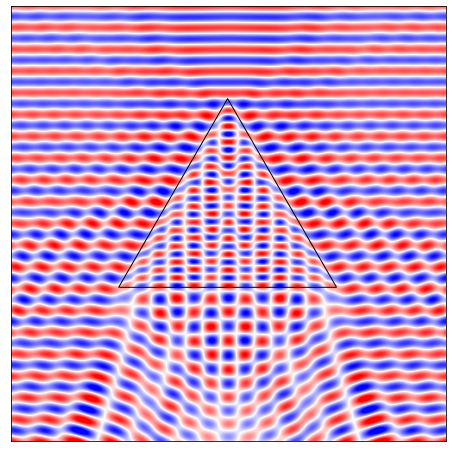

In [213]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
matplotlib.rcParams.update({'font.size': 20})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
start = 20
# plt.imshow((np.real((u_total[start:-start,start:-start]))), extent=[x[start],x[-start],y[start],y[-start]],cmap=plt.cm.get_cmap('bwr'), interpolation='spline16')
plt.imshow(np.flipud(np.real(u_total[start:-start,start:-start])), extent=[x[start],x[-start],y[start],y[-start]],cmap=plt.cm.get_cmap('bwr'), interpolation='spline16')

polygon = Polygon(verts, facecolor="none", 
              edgecolor='black', lw=1)
plt.gca().add_patch(polygon)

# # Finite difference grid
# ax.get_xaxis().set_ticks(x)
# ax.xaxis.set_ticklabels([])
# ax.get_yaxis().set_ticks(y)
# ax.yaxis.set_ticklabels([])
# ax.grid(linestyle='-', linewidth=0.5, color='black')
# plt.box(on=None)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
# plt.scatter(x_s.real, x_s.imag, color='black', s=5)

# plt.colorbar()
plt.clim(-1.5, 1.5)

plt.show()
# fig.savefig('results/tri_k10_0i_bwr.png')
# plt.close()